In [ ]:
import sys
import os

# Переход в корневую директорию проекта
project_root = os.path.abspath("..")  # Выход из папки notebooks
sys.path.append(project_root)




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from db_init import SessionLocal, engine
from tables import AnimeInfo, AnimeRatings
from catboost import CatBoostRegressor
session = SessionLocal()


In [2]:

def batch_load_sql(query) -> pd.DataFrame:
    CHUNKSIZE = 200000
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(str(query.statement), conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)

In [4]:

query_anime_info = session.query(AnimeInfo)
query_anime_ratings = session.query(AnimeRatings)
df_anime_ratings = batch_load_sql(query_anime_ratings)

df_anime_info = batch_load_sql(query_anime_info)
df_anime_ratings = batch_load_sql(query_anime_ratings)




In [5]:
df_merged = pd.merge(
    df_anime_ratings,
    df_anime_info,
    left_on="Anime_ID",
    right_on="anime_ids",
    how="left",
)
df_merged.head()

,User_ID,Anime_ID,Feedback,anime_ids,name,genre,type,episodes,rating,members
0,1,1,8,1,D.N.Angel,"Action, Comedy, Fantasy, Magic, Romance, Schoo...",TV,26,7.35,126914
1,1,3,5,3,Bokusatsu Tenshi Dokuro-chan,"Comedy, Ecchi, Magic",OVA,4,6.85,117080
2,1,5,9,5,Bokura ga Ita,"Drama, Romance, Shoujo, Slice of Life",TV,26,7.54,125051
3,1,6,9,6,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
4,1,7,8,7,Clannad,"Comedy, Drama, Romance, School, Slice of Life,...",TV,23,8.30,566690


In [6]:
df_merged.isna().sum()

User_ID      0
Anime_ID     0
Feedback     0
anime_ids    0
name         0
genre        0
type         0
episodes     0
rating       0
members      0
dtype: int64

In [7]:
df_merged.columns

Index(['User_ID', 'Anime_ID', 'Feedback', 'anime_ids', 'name', 'genre', 'type',
       'episodes', 'rating', 'members'],
      dtype='object')

In [8]:
df_merged['genre'] = df_merged['genre'].str.split(', ')


In [15]:
df_merged.explode('genre')['genre'].value_counts()


genre
Comedy           208247
Action           177319
Romance          134575
Drama            114345
Fantasy          108720
Supernatural     107767
School           102035
Shounen          101006
Adventure         90375
Sci-Fi            86772
Slice of Life     59244
Ecchi             50194
Mystery           49286
Super Power       42561
Magic             41257
Seinen            41118
Harem             40433
Psychological     31653
Mecha             30360
Shoujo            26268
Horror            24028
Military          23938
Historical        20105
Thriller          19803
Demons            18149
Parody            14875
Martial Arts      13840
Sports            12960
Vampire           12409
Game              11900
Music             10741
Space              9624
Police             8855
Kids               6660
Samurai            6358
Hentai             5244
Josei              4033
Dementia           3599
Shoujo Ai          3536
Shounen Ai         3161
Yaoi               1607
Cars      

In [17]:
import seaborn as sns

In [30]:
df_merged.groupby('Anime_ID')


,User_ID,Anime_ID,Feedback,anime_ids,name,genre,type,episodes,rating,members
0,1,1,8,1,D.N.Angel,"[Action, Comedy, Fantasy, Magic, Romance, Scho...",TV,26,7.35,126914
1,1,3,5,3,Bokusatsu Tenshi Dokuro-chan,"[Comedy, Ecchi, Magic]",OVA,4,6.85,117080
2,1,5,9,5,Bokura ga Ita,"[Drama, Romance, Shoujo, Slice of Life]",TV,26,7.54,125051
3,1,6,9,6,Death Note,"[Mystery, Police, Psychological, Supernatural,...",TV,37,8.71,1013917
4,1,7,8,7,Clannad,"[Comedy, Drama, Romance, School, Slice of Life...",TV,23,8.30,566690
...,...,...,...,...,...,...,...,...,...,...
418634,4979,6020,9,6020,Tongari Boushi no Memole,"[Fantasy, Magic, Shoujo]",TV,50,7.11,1009
419092,4982,4707,6,4707,Sekiei Ayakashi Mangatan,"[Fantasy, Historical, Supernatural]",ONA,3,5.87,2615
419322,4987,6975,7,6975,Mini Skirt Gakuen,[Hentai],OVA,1,4.64,657
419324,4987,6733,7,6733,Onna Kyoushi,[Hentai],OVA,3,6.24,1570


<Axes: xlabel='count', ylabel='Count'>

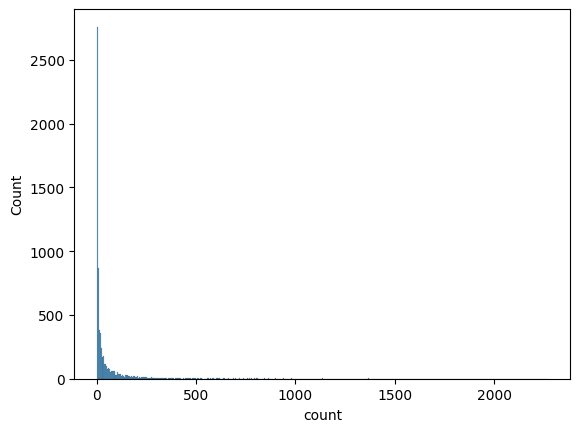

In [23]:
sns.histplot(df_merged.groupby('Anime_ID')['name'].value_counts())

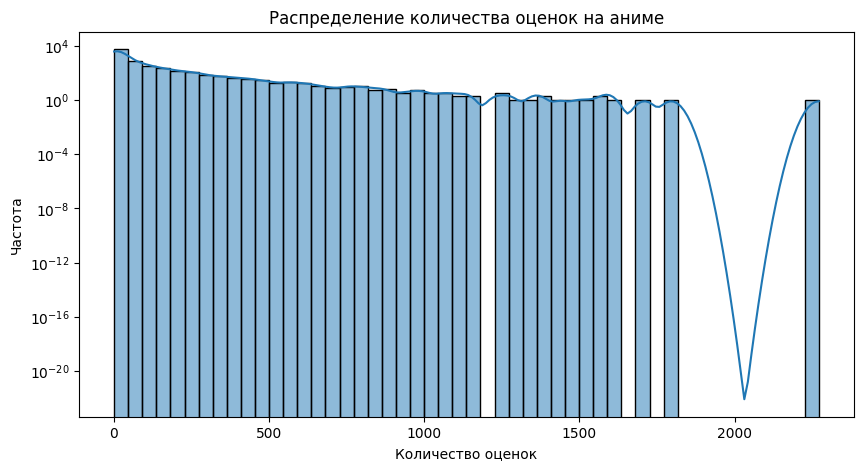

In [31]:
anime_feedback_counts = df_merged['Anime_ID'].value_counts()
plt.figure(figsize=(10, 5))
sns.histplot(anime_feedback_counts, bins=50, kde=True)
plt.xlabel('Количество оценок')
plt.ylabel('Частота')
plt.title('Распределение количества оценок на аниме')
plt.yscale('log')  # Логарифмическая шкала для удобства
plt.show()

In [35]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(df_merged['genre']), columns=mlb.classes_)

# Добавляем к основному датасету
df_merged = pd.concat([df_merged, genre_encoded], axis=1)


In [44]:
from sklearn.model_selection import train_test_split

train_users, test_users = train_test_split(df_merged['User_ID'].unique(), test_size=0.2)

df_train = df_merged[df_merged['User_ID'].isin(train_users)]
df_test = df_merged[df_merged['User_ID'].isin(test_users)]



In [37]:
def hitrate_at_k(recommendations, test_data, k=5):
    hits = 0
    total = 0
    
    for user_id in test_data['User_ID'].unique():
        actual_watched = set(test_data[test_data['User_ID'] == user_id]['Anime_ID'])
        recommended = set(recommendations.get(user_id, [])[:k])
        
        if recommended & actual_watched:
            hits += 1
        total += 1

    return hits / total

# Пример вызова: hitrate_at_k(recommendations_dict, df_merged, k=5)



In [45]:
from catboost import CatBoostRegressor

# Выбираем признаки
features = ['type', 'episodes', 'rating', 'members'] + list(genre_encoded.columns)
target = 'Feedback'

# Создаем и обучаем модель
model = CatBoostRegressor(
    iterations=500, 
    depth=8,  
    learning_rate=0.05,  
    l2_leaf_reg=10,  # Усиление регуляризации
    loss_function='RMSE', 
    cat_features=['type'], 
    early_stopping_rounds=30,  # Даем больше шансов улучшиться
    verbose=50
)
model.fit(df_train[features], df_train[target], eval_set=(df_test[features], df_test[target]), early_stopping_rounds=20)


0:	learn: 1.5729426	test: 1.5709642	best: 1.5709642 (0)	total: 56.6ms	remaining: 28.2s
50:	learn: 1.4515182	test: 1.4577235	best: 1.4577235 (50)	total: 3.39s	remaining: 29.8s
100:	learn: 1.4489983	test: 1.4564382	best: 1.4564382 (100)	total: 6.3s	remaining: 24.9s
150:	learn: 1.4480512	test: 1.4563753	best: 1.4563434 (139)	total: 9.2s	remaining: 21.3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1.456343364
bestIteration = 139

Shrink model to first 140 iterations.


In [46]:
predictions = model.predict(df_test[features])

# Формируем рекомендации
df_test['predicted_score'] = predictions
recommendations = df_test.groupby('User_ID').apply(lambda x: x.sort_values('predicted_score', ascending=False)['Anime_ID'].tolist())

# Считаем hitrate@5
hitrate = hitrate_at_k(recommendations, df_test, k=5)
print(f'Hitrate@5: {hitrate:.4f}')


/tmp/ipykernel_61088/3996653957.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predicted_score'] = predictions
/tmp/ipykernel_61088/3996653957.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommendations = df_test.groupby('User_ID').apply(lambda x: x.sort_values('predicted_score', ascending=False)['Anime_ID'].tolist())


Hitrate@5: 1.0000


In [47]:
from sklearn.metrics import mean_squared_error

mean_squared_error(df_test['Feedback'],predictions)

2.1209359926523796

In [48]:
model.save_model("catboost_recommender.cbm")

